Upsampling dataset for each time frame: linear vs forward filling interpolation 

In [40]:
# Importing required files and libraries

import json
from pathlib import Path

import sleap_io as sio
from matplotlib import pyplot as plt

from movement import sample_data
from movement.filtering import interpolate_over_time
from movement.io import load_bboxes
from movement.validators.files import ValidVIATracksCSV

In [22]:
# Fetch and Load dataset
# In this tutorial, we will use a sample bounding boxes dataset with
# a single individual (a crab). The clip is part of the `Moving
# Camouflaged Animals Dataset (MoCA) dataset


dataset_dict = sample_data.fetch_dataset_paths(
    "VIA_single-crab_MOCA-crab-1.csv",
    with_video=True,  # download associated video
)
file_path = dataset_dict["bboxes"]
print(file_path)

ds = load_bboxes.from_via_tracks_file(
    file_path, use_frame_numbers_from_file=True
)

/home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA-crab-1.csv


In [20]:
# The loaded dataset is made up of three data arrays:
# ``position``, ``shape``, and ``confidence``.

# We can see that the coordinates in the time dimension are expressed in
# frames, and that we only have data for 1 in 5 frames of the video, plus
# the last frame (frame number 167).


print(ds)

# Inspecting associated video
video_path = dataset_dict["video"]
video = sio.load_video(video_path)
n_frames, height, width, channels = video.shape

print(f"Number of frames: {n_frames}")
print(f"Frame size: {width}x{height}")
print(f"Number of channels: {channels}")

print(ds.time)

<xarray.Dataset> Size: 2kB
Dimensions:      (time: 35, space: 2, individuals: 1)
Coordinates:
  * time         (time) int64 280B 0 5 10 15 20 25 ... 145 150 155 160 165 167
  * space        (space) <U1 8B 'x' 'y'
  * individuals  (individuals) <U4 16B 'id_1'
Data variables:
    position     (time, space, individuals) float64 560B 1.118e+03 ... 401.9
    shape        (time, space, individuals) float64 560B 320.1 153.2 ... 120.1
    confidence   (time, individuals) float64 280B nan nan nan ... nan nan nan
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  VIA-tracks
    source_file:      /home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA...
    ds_type:          bboxes
Number of frames: 168
Frame size: 1280x720
Number of channels: 3
<xarray.DataArray 'time' (time: 35)> Size: 280B
0 5 10 15 20 25 30 35 40 45 50 ... 120 125 130 135 140 145 150 155 160 165 167
Coordinates:
  * time     (time) int64 280B 0 5 10 15 20 25 30 ... 145 150 155 160 165 1


### Forward Fill Interpolation

We apply forward fill to the position and shape arrays, using the last valid value to fill missing frames. This keeps the box's position and shape constant when no new annotation is available.

The confidence array is not forward-filled, as propagating its value isn't meaningful — it’s instead filled using linear interpolation.

In [ ]:
ds_ff = ds.reindex(
    {"time": list(range(ds.time[-1].item() + 1))},
    method="ffill",  # propagate last valid index value forward
)

print(ds_ff)
print(ds_ff.time)

<xarray.Dataset> Size: 8kB
Dimensions:      (time: 168, space: 2, individuals: 1)
Coordinates:
  * time         (time) int64 1kB 0 1 2 3 4 5 6 ... 161 162 163 164 165 166 167
  * space        (space) <U1 8B 'x' 'y'
  * individuals  (individuals) <U4 16B 'id_1'
Data variables:
    position     (time, space, individuals) float64 3kB 1.118e+03 ... 401.9
    shape        (time, space, individuals) float64 3kB 320.1 153.2 ... 120.1
    confidence   (time, individuals) float64 1kB nan nan nan nan ... nan nan nan
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  VIA-tracks
    source_file:      /home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA...
    ds_type:          bboxes
<xarray.DataArray 'time' (time: 168)> Size: 1kB
0 1 2 3 4 5 6 7 8 9 10 11 12 ... 156 157 158 159 160 161 162 163 164 165 166 167
Coordinates:
  * time     (time) int64 1kB 0 1 2 3 4 5 6 7 ... 161 162 163 164 165 166 167


### LInear Interpolation 

We apply linear interpolation to the position and shape arrays to smoothly fill missing frames. This method estimates intermediate values between two valid frames — useful when there's a significant change (e.g., from (0, 0) to (10, 10)) and we want a gradual transition.

Interpolation is performed over the time dimension using movement.filtering.interpolate_over_time, which fills all gaps (max_gap=None) based on the time coordinates of the data.

In [ ]:
ds_nan = ds.reindex(
    {"time": list(range(ds.time[-1].item() + 1))},
    method=None,  # Default
)

ds_interp = ds_nan.copy()

# Perform linear interpolation
for data_array_str in ["position", "shape"]:
    ds_interp[data_array_str] = interpolate_over_time(
        data=ds_interp[data_array_str],
        method="linear",
        max_gap=None,
        print_report=False,
    )

print(ds_interp)
print(ds_interp.time)

<xarray.Dataset> Size: 8kB
Dimensions:      (time: 168, space: 2, individuals: 1)
Coordinates:
  * time         (time) int64 1kB 0 1 2 3 4 5 6 ... 161 162 163 164 165 166 167
  * space        (space) <U1 8B 'x' 'y'
  * individuals  (individuals) <U4 16B 'id_1'
Data variables:
    position     (time, space, individuals) float64 3kB 1.118e+03 ... 401.9
    shape        (time, space, individuals) float64 3kB 320.1 153.2 ... 120.1
    confidence   (time, individuals) float64 1kB nan nan nan nan ... nan nan nan
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  VIA-tracks
    source_file:      /home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA...
    ds_type:          bboxes
<xarray.DataArray 'time' (time: 168)> Size: 1kB
0 1 2 3 4 5 6 7 8 9 10 11 12 ... 156 157 158 159 160 161 162 163 164 165 166 167
Coordinates:
  * time     (time) int64 1kB 0 1 2 3 4 5 6 7 ... 161 162 163 164 165 166 167


Checking the Values : Original , Linear Upsampling and  Forward Filling 

In [29]:
# Print original dataset for verification
print("Original dataset")
for t in [0, 5, 10]:
    print(f"Time {t}: {ds.position.sel(time=t).data}")

# Print upsampled dataset
print("Linear Upsampled dataset")
for t in range(11):
    print(f"Time {t}: {ds_interp.position.sel(time=t).data}")


# Print upsampled dataset
print("Forward filled Upsampled dataset")
for t in range(11):
    print(f"Time {t}: {ds_ff.position.sel(time=t).data}")

Original dataset
Time 0: [[1117.895 ]
 [ 373.3035]]
Time 5: [[1098.141 ]
 [ 376.1255]]
Time 10: [[1072.7435]
 [ 384.5915]]
Linear Upsampled dataset
Time 0: [[1117.895 ]
 [ 373.3035]]
Time 1: [[1113.9442]
 [ 373.8679]]
Time 2: [[1109.9934]
 [ 374.4323]]
Time 3: [[1106.0426]
 [ 374.9967]]
Time 4: [[1102.0918]
 [ 375.5611]]
Time 5: [[1098.141 ]
 [ 376.1255]]
Time 6: [[1093.0615]
 [ 377.8187]]
Time 7: [[1087.982 ]
 [ 379.5119]]
Time 8: [[1082.9025]
 [ 381.2051]]
Time 9: [[1077.823 ]
 [ 382.8983]]
Time 10: [[1072.7435]
 [ 384.5915]]
Forward filled Upsampled dataset
Time 0: [[1117.895 ]
 [ 373.3035]]
Time 1: [[1117.895 ]
 [ 373.3035]]
Time 2: [[1117.895 ]
 [ 373.3035]]
Time 3: [[1117.895 ]
 [ 373.3035]]
Time 4: [[1117.895 ]
 [ 373.3035]]
Time 5: [[1098.141 ]
 [ 376.1255]]
Time 6: [[1098.141 ]
 [ 376.1255]]
Time 7: [[1098.141 ]
 [ 376.1255]]
Time 8: [[1098.141 ]
 [ 376.1255]]
Time 9: [[1098.141 ]
 [ 376.1255]]
Time 10: [[1072.7435]
 [ 384.5915]]


In [30]:
# We can verify with a plot that the empty values have been filled in
# using the last valid value in time.
#
# For this we define a convenience function to plot the x and y coordinates
# of the ``position`` and  ``shape`` arrays, for the input dataset and for
# a filled one.


def plot_position_and_shape_xy_coords(ds_input, ds_filled, color_filled):
    """Compare the x and y coordinates of the position and shape arrays in
    time for the input and filled datasets.
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    space_coords = ["x", "y"]
    data_array_names = ["position", "shape"]

    for row, space_coord in enumerate(space_coords):
        for col, data_array in enumerate(data_array_names):
            ax = axs[row, col]
            ax.scatter(
                x=ds_input.time,
                y=ds_input[data_array].sel(
                    individuals="id_1", space=space_coord
                ),
                marker="o",
                color="black",
                label="original data",
            )
            ax.plot(
                ds_filled.time,
                ds_filled[data_array].sel(
                    individuals="id_1", space=space_coord
                ),
                marker=".",
                linewidth=1,
                color=color_filled,
                label="upsampled data",
            )
            ax.set_ylabel(f"{space_coord} (pixels)")
            if row == 0:
                ax.set_title(f"Bounding box {data_array}")
                if col == 1:
                    ax.legend()
            if row == 1:
                ax.set_xlabel("Time (frames)")

    fig.tight_layout()

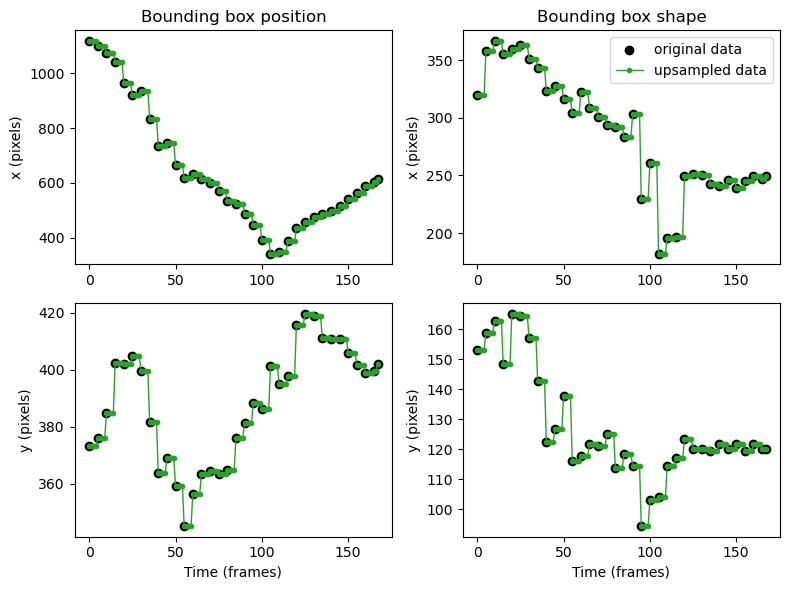

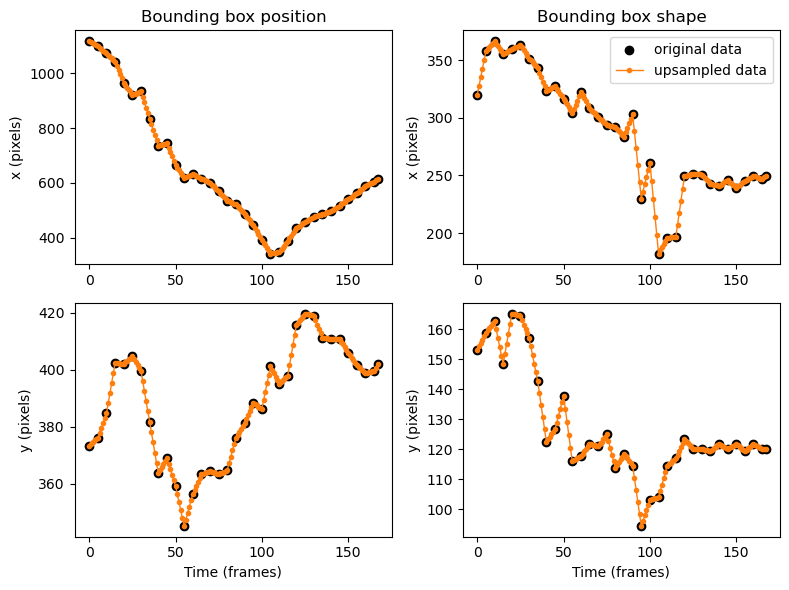

In [31]:
# In the plot below, the original ``position`` and ``shape`` data is shown
# in black, while the forward-filled values are shown in green and the linear upsampled value are shown in orange


plot_position_and_shape_xy_coords(
    ds, ds_filled=ds_ff, color_filled="tab:green"
)


plot_position_and_shape_xy_coords(
    ds, ds_filled=ds_interp, color_filled="tab:orange"
)

Which is Better ? 

From the Plots for both forward filling and linear interpolation we can clearly see that the linear interpolation gives a better smooth transitions between positons at each time frames as compared to forward filling which has sharp turns at each change in value. 

In the below code, the XArray datasets are being converted to VIA CSV format, these files can be loaded in napari and checked for the centroid tracking of the animal

In [41]:
# Convert to VIA format and save
def convert_to_via_format(ds, filename):
    """Convert Xarray dataset to VIA CSV format with
    correctly formatted bounding boxes.
    """
    df = ds.to_dataframe().reset_index()

    # Pivot data to organize x, y, width, height correctly
    df_pivot = df.pivot(
        index=["time"], columns="space", values=["position", "shape"]
    )

    # Flatten multi-index column names
    df_pivot.columns = ["x_center", "y_center", "width", "height"]
    df_pivot = df_pivot.reset_index()

    # Convert centroid back to top-left corner
    df_pivot["x"] = df_pivot["x_center"] - df_pivot["width"] / 2
    df_pivot["y"] = df_pivot["y_center"] - df_pivot["height"] / 2

    # Generate correct filenames
    df_pivot["filename"] = df_pivot["time"].apply(
        lambda t: f"/crab_1/{t:05d}.jpg"
    )

    # Add metadata fields
    df_pivot["file_size"] = 0
    df_pivot["file_attributes"] = json.dumps({"shot": 123})
    df_pivot["region_count"] = 1
    df_pivot["region_id"] = 0
    df_pivot["region_attributes"] = json.dumps({"track": 1})

    # Convert into VIA bounding box format
    df_pivot["region_shape_attributes"] = df_pivot.apply(
        lambda row: json.dumps(
            {
                "name": "rect",
                "x": row["x"],  # Corrected Top-Left Corner
                "y": row["y"],  # Corrected Top-Left Corner
                "width": row["width"],
                "height": row["height"],
            }
        ),
        axis=1,
    )

    # Keep only required columns
    df_final = df_pivot[
        [
            "filename",
            "file_size",
            "file_attributes",
            "region_count",
            "region_id",
            "region_shape_attributes",
            "region_attributes",
        ]
    ]

    # Save to CSV
    df_final.to_csv(filename, index=False)
    print(f"Saved: {filename}")


convert_to_via_format(ds_ff, "check_ffupsampled_dataset.csv")
convert_to_via_format(ds_interp, "check_linearupsampled_dataset.csv")
# The resulting CSV file can be opened with the VIA tool

Saved: check_ffupsampled_dataset.csv
Saved: check_linearupsampled_dataset.csv


Using the  file validators to ensure the generated files are importable into movement. The simplest way would be to check is if we can successfully create a ValidVIAtracksCSV object doing the following before exporting the csv:

In [ ]:
file = ValidVIATracksCSV(Path("check_ffupsampled_dataset.csv"))
file = ValidVIATracksCSV(Path("check_linearupsampled_dataset.csv"))

So, we can sucessfully use this method to interpolate the data and use it for better visualization results  